# SMEAR data preprocessing

Basic prepocessing functionality

- merges SMEAR parameters and negative ion data
- checks for missing timestamps and timestamp continuity
- does not include any advanced transformations 
- plots missing data as heatmap


Currently only for Värriö on Hyytiälä, but Siikaneva and Kumpula can be easily added by similar code lines. 

In [1]:
# imports

import pandas as pd
import sys
from file_config import FILE_PATHS
from utils.df_utils import get_valid_date_stamps, check_timestamp_continuity, plot_missing_data_heatmap, filter_by_month_interval, filter_by_year_interval


In [2]:
# configure path
sys.path.append("../src")  # Ensure src is in Python path if not already

In [3]:
# read raw data csv files
hyy_ambient_df = pd.read_csv(FILE_PATHS['hyy_raw'])
hyy_neg_ions_df = pd.read_csv(FILE_PATHS['hyy_neg_ions_csv'])

var_ambient_df = pd.read_csv(FILE_PATHS['var_raw'])
var_neg_ions_df = pd.read_csv(FILE_PATHS['var_neg_ions_csv'])

## 

## Valid date range

Cell below checks valid date range for each parameter, and saves amended metadata file with. This may not be totally necessary step, but may be helpful in exploring the data. 

In [4]:
# add min and max valid date columns to metadata 

valid_range_hyy_ambient = get_valid_date_stamps(hyy_ambient_df, 'Datetime')
valid_range_hyy_neg_ions = get_valid_date_stamps(hyy_neg_ions_df, 'date')
valid_range_var_ambient = get_valid_date_stamps(var_ambient_df, 'Datetime')
valid_range_var_neg_ions = get_valid_date_stamps(var_neg_ions_df, 'date')

hyy_meta = pd.read_csv(FILE_PATHS['hyy_metadata'])
var_meta = pd.read_csv(FILE_PATHS['var_metadata'])


valid_range_hyy_ambient[['tableId', 'name']] = valid_range_hyy_ambient['data_column'].str.split('.', expand=True)
valid_range_var_ambient[['tableId', 'name']] = valid_range_var_ambient['data_column'].str.split('.', expand=True)


merged_hyy_meta = hyy_meta.merge(valid_range_hyy_ambient[['tableId', 'name', 'first_valid_date', 'last_valid_date']], 
                           on=['tableId', 'name'], how='left')

merged_var_meta = var_meta.merge(valid_range_var_ambient[['tableId', 'name', 'first_valid_date', 'last_valid_date']], 
                           on=['tableId', 'name'], how='left')


merged_hyy_meta.to_csv(FILE_PATHS['hyy_metadata_range'], index=False)
merged_var_meta.to_csv(FILE_PATHS['var_metadata_range'], index=False)

## Check for missing timestamps

Number of missing timestamps are checked for negative ion concentration and downloaded SMEAR data. 

Negative ion concentration measurement data may miss timestamps, but SMEAR data should not miss any timestamps. 

In [5]:
# check for missign timestamps

hyy_ambient_missing_timestamps = check_timestamp_continuity(hyy_ambient_df, 'Datetime')
hyy_neg_ions_missing_timestamps = check_timestamp_continuity(hyy_neg_ions_df, 'date')
var_ambient_missing_timestamps = check_timestamp_continuity(var_ambient_df, 'Datetime')
var_neg_ions_missing_timestamps = check_timestamp_continuity(var_neg_ions_df, 'date')

print(f'Hyytiälä ambient number of missing timestamps: {len(hyy_ambient_missing_timestamps)} out of {len(hyy_ambient_df)}')
print(f'Hyytiälä negative ions data number of missing timestamps: {len(hyy_neg_ions_missing_timestamps)} out of {len(hyy_neg_ions_df)}')
print(f'Värriö ambient number of missing timestamps: {len(var_ambient_missing_timestamps)} out of {len(var_ambient_df)}')
print(f'Värriö negative ions data number of missing timestamps: {len(var_neg_ions_missing_timestamps)} out of {len(var_neg_ions_df)}')


Hyytiälä ambient number of missing timestamps: 0 out of 255599
Hyytiälä negative ions data number of missing timestamps: 30864 out of 224736
Värriö ambient number of missing timestamps: 0 out of 100943
Värriö negative ions data number of missing timestamps: 48 out of 100896


## Merge

Merge negative ion data with ambient data, and check for missing timestamps. There should be no missing timestamps after merging. 


Save merged data as local ```.csv`` files. These are the files used by the pipeline. 

In [ ]:
# Merge negative ions data with ambient data

hyy_merged = hyy_ambient_df.merge(hyy_neg_ions_df, left_on='Datetime', right_on='date', how='left')
hyy_merged = hyy_merged.drop(columns=['date'])
var_merged = var_ambient_df.merge(var_neg_ions_df, left_on='Datetime', right_on='date', how='left')
var_merged = var_merged.drop(columns=['date'])


hyy_merged_missing_timestamps = check_timestamp_continuity(hyy_merged, 'Datetime')
var_merged_missing_timestamps = check_timestamp_continuity(var_merged, 'Datetime')

print(f'Hyytiälä merged data timestamp continuity: {len(hyy_merged_missing_timestamps)} out of {len(hyy_merged)}')
print(f'Värriö merged data timestamp continuity: {len(var_merged_missing_timestamps)} out of {len(var_merged)}')

hyy_merged.to_csv(FILE_PATHS['hyy_combined'], index=False)
var_merged.to_csv(FILE_PATHS['var_combined'], index=False)


Hyytiälä merged data timestamp continuity: 0 out of 255599
Värriö merged data timestamp continuity: 0 out of 100943


## Investigate missing values

Plot missing data per variable as heatmaps

Missing periods for Värriö:


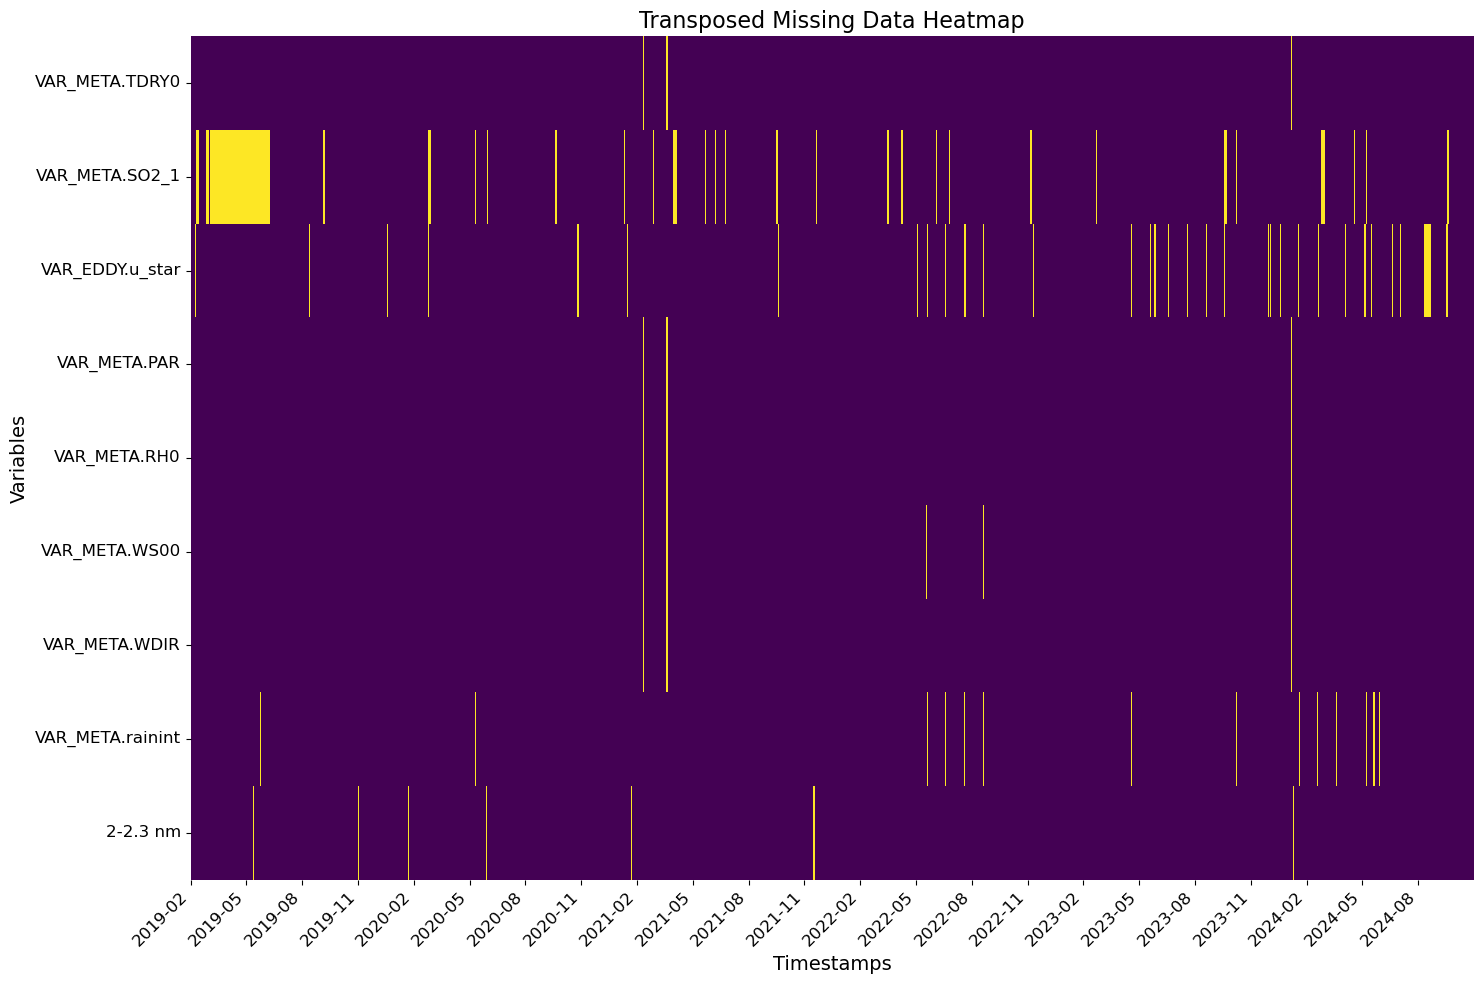

Missing periods for Hyytiälä:


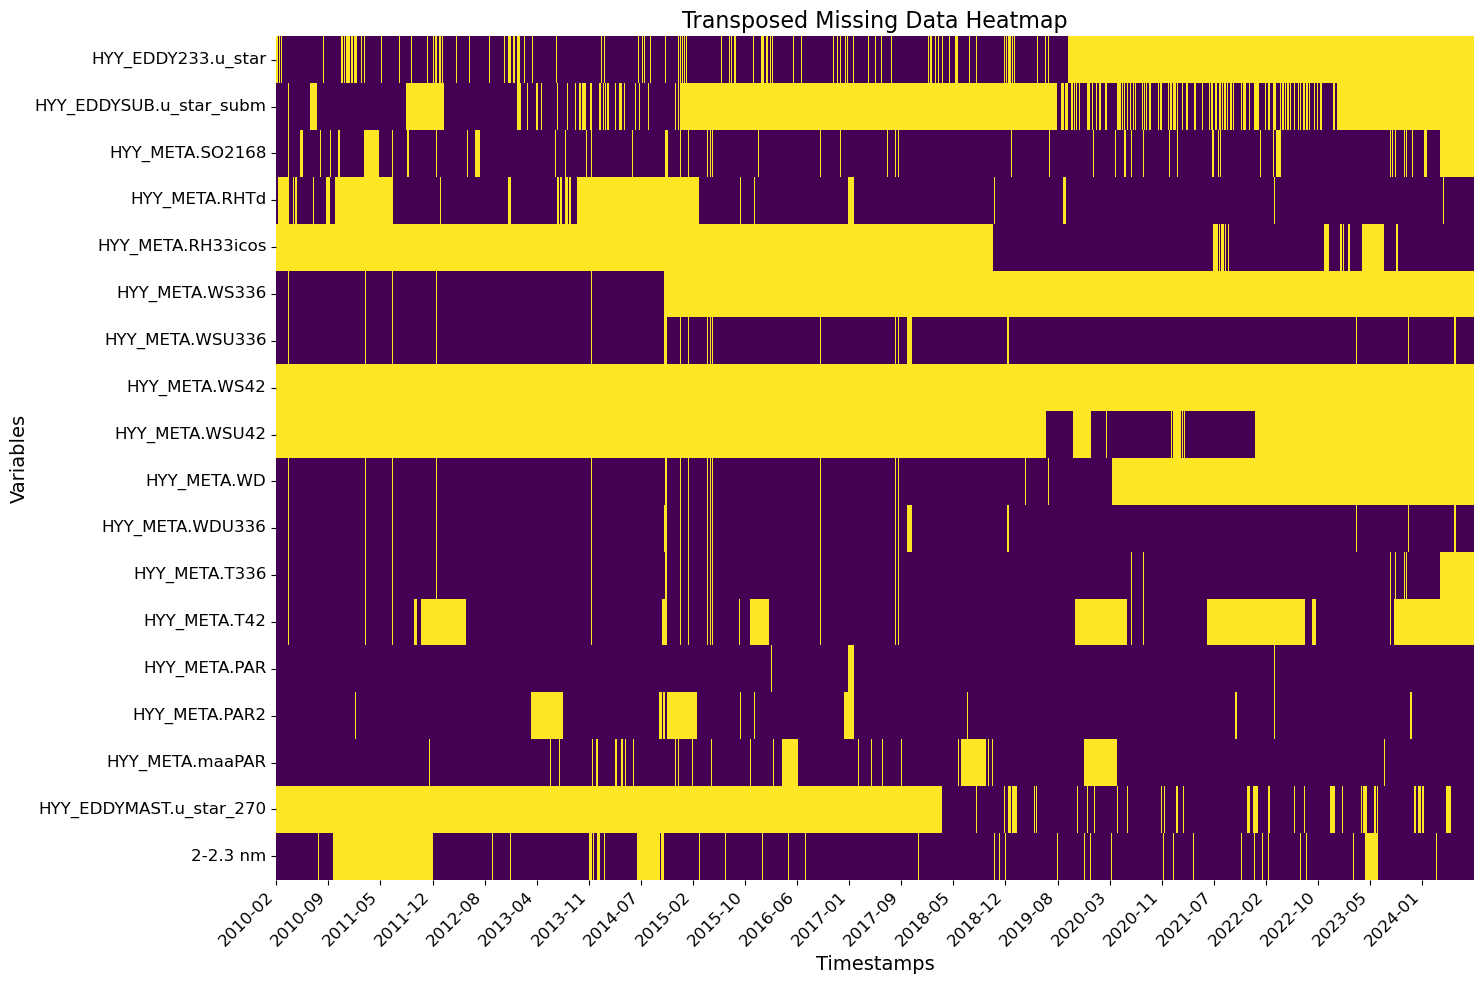

In [7]:
# plot missing data heatmap
print("Missing periods for Värriö:")
plot_missing_data_heatmap(var_merged, 'Datetime', transpose=True)

print("Missing periods for Hyytiälä:")
plot_missing_data_heatmap(hyy_merged, 'Datetime', transpose=True)

Choose only summer periods and plot missing data again

Värriö summer months: 7 - 8
Missing periods for Värriö in summer:
Target variable missing from Värriö summers 37 out of 17856


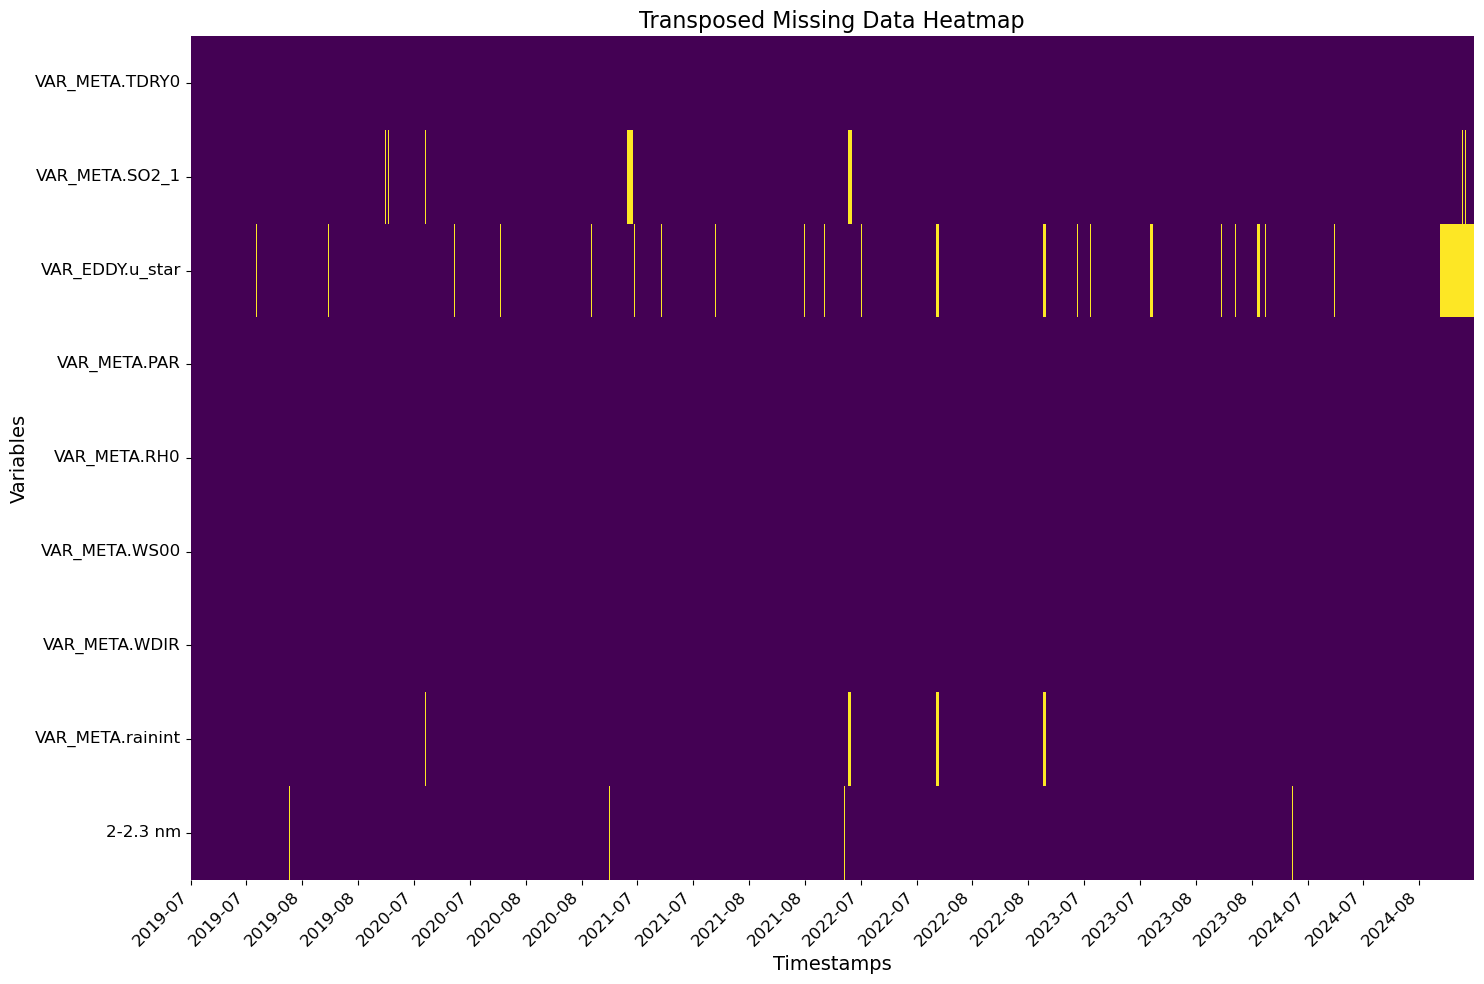

Hyytiälä summer months 6 - 8
Missing periods for Hyytiälä in summer:


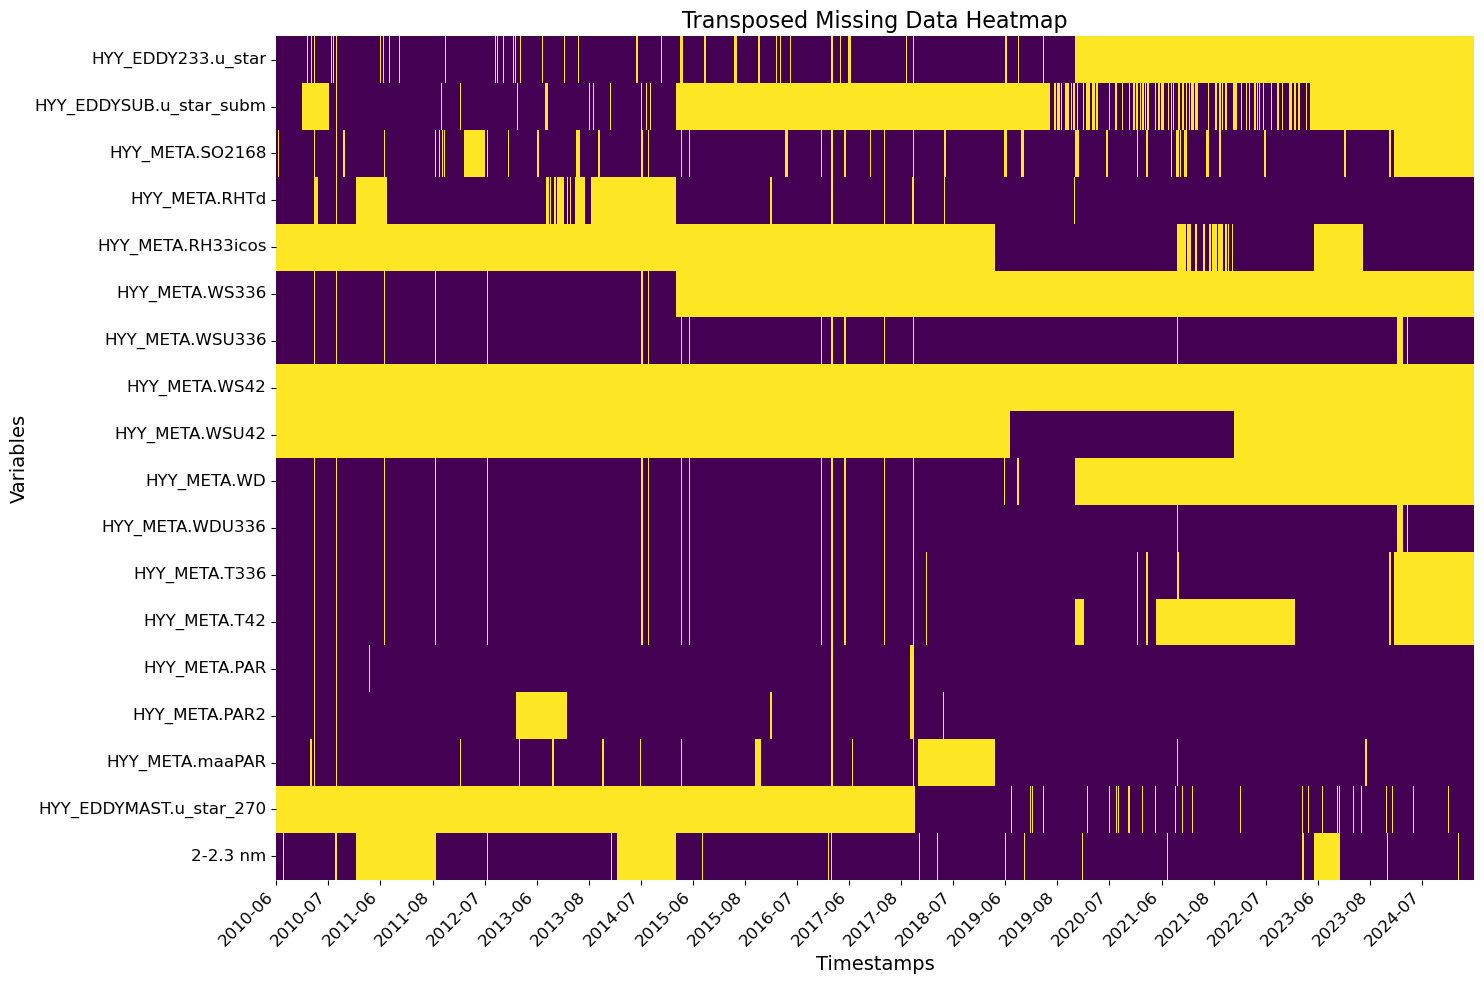

In [8]:
#choose only summer months and plot missing data heatmap

var_summer_months = (7,8)
print(f'Värriö summer months: {var_summer_months[0]} - {var_summer_months[1]}')##ffsssfdf85 sssssssssaaaaaassxxx
var_summer = filter_by_month_interval(var_merged, 'Datetime', var_summer_months[0], var_summer_months[1])
print("Missing periods for Värriö in summer:")
print(f'Target variable missing from Värriö summers {var_summer["2-2.3 nm"].isnull().sum()} out of {len(var_summer)}')
plot_missing_data_heatmap(var_summer, 'Datetime', transpose=True)
var_summer.to_csv(FILE_PATHS['var_summer_csv'], index=False)


hyy_summmer_months = (6,8)
print(f'Hyytiälä summer months {hyy_summmer_months[0]} - {hyy_summmer_months[1]}')
hyy_summer = filter_by_month_interval(hyy_merged, 'Datetime', hyy_summmer_months[0], hyy_summmer_months[1])
print("Missing periods for Hyytiälä in summer:")
plot_missing_data_heatmap(hyy_summer, 'Datetime', transpose=True)



Hyytiälä missing data when rows with target variable `2-2.3 nm` missing are dropped

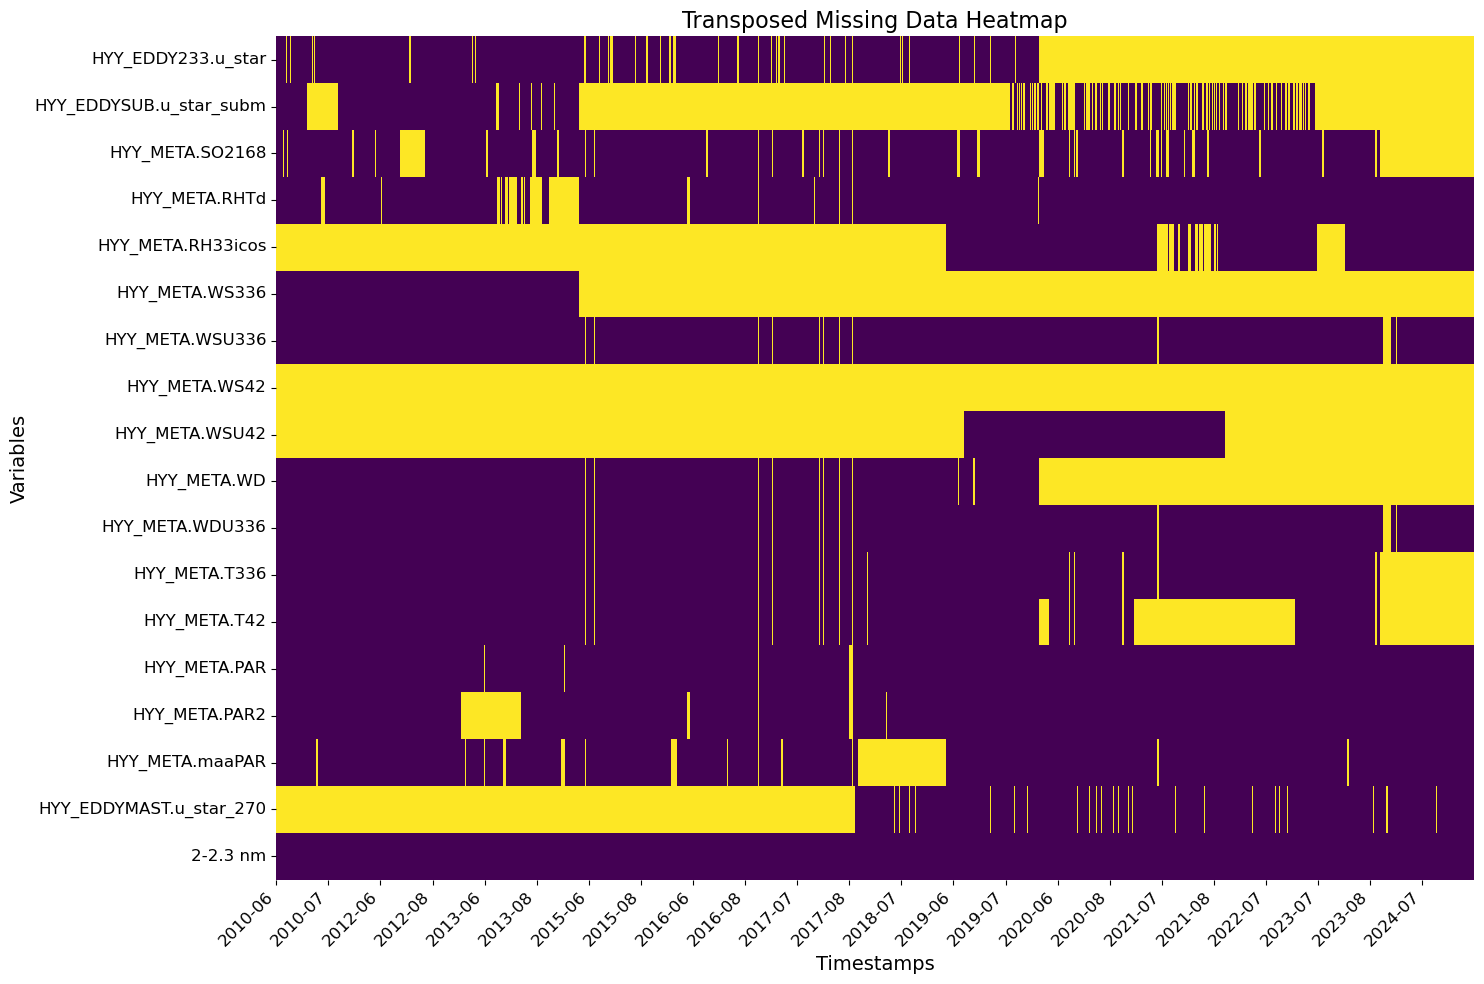

In [9]:
# Hyytiälä: drop rows with missing ion data

hyy_merged_temp = hyy_summer.dropna(subset=['2-2.3 nm'])


plot_missing_data_heatmap(hyy_merged_temp, 'Datetime', transpose=True)
